In [78]:
import os
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from src.env import PROJECT_DIR

In [2]:
file_names = [
    '20170101-20181231.csv',
    '20190101-20191231.csv',
    '20200101-20200731.csv']

In [104]:
data_dir = PROJECT_DIR / 'data' / 'raw'
media_dfs = dict()

for outlet in os.scandir(data_dir):
    if not os.path.isdir(outlet):
        continue
    dfs = []
    for f in os.scandir(outlet.path):
        if f.name not in file_names:
            continue
        dfs.append(pd.read_csv(f.path))
        
    df = pd.concat(dfs)
    media_dfs[outlet.name] = df

Compile regexes

In [35]:
square_brackets = re.compile(r'\[(.+)\]')
sentence_break = re.compile(r'\.[\s\'"\)\>\?!]')
quotation_marks = re.compile(r'[‘’“”"\']')
open_brackets = re.compile(r'(?<=[^\s])([\[\(\{\<])')
close_brackets = re.compile(r'([\]\)\}\>])(?=[^\s])')

In [5]:
def get_article_label_if_exists(title):
    match_res = square_brackets.match(title)
    if match_res is None:
        return None
    else:
        return match_res.groups()[0]

In [105]:
dfs = dict()
for k, df in media_dfs.items():
    v = df.copy()
    
    # Parse datetime
    v.loc[:, 'datetime'] = pd.to_datetime(v.date)
    
    # Extract article labels if it exists
    v.loc[:, 'extracted_category'] = v.title.apply(get_article_label_if_exists)
    
    # TODO: Remove [<source>]
    source_tag = re.compile(r'^\[' + k + r'\]')
    v.loc[:, 'text'] = v.text.apply(lambda text: source_tag.sub('', text))
    
    # Remove quotation marks
    v.loc[:, 'text'] = v.text.apply(lambda text: quotation_marks.sub('', text))
    
    # Add spaces around brackets
    v.loc[:, 'text'] = v.text.apply(lambda text: open_brackets.sub(r' \1', text))
    v.loc[:, 'text'] = v.text.apply(lambda text: close_brackets.sub(r'\1 ', text))
    
    # Break into sentences
    v.loc[:, 'sentences'] = v.text.apply(lambda text: sentence_break.split(text))
    
    v = v.set_index('datetime')
    v.drop(columns=['date'], inplace=True)
    
    # Sort
    v = v.sort_index()
    dfs[k] = v

In [106]:
dfs['경향신문'].head(10)

,title,summary,text,extracted_category,sentences
datetime,,,,,
2017-01-03 18:00:00,"대선주자 인터뷰②이재명 ""나? 좋은 사람 아니라 부패척결 머슴..문재인은 점잖은 성군""",NaN,\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 이재명 성남...,None,[\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 이재명 성...
2017-01-03 22:29:00,"[2017 대선의 꿈]②이재명 성남시장 ""혁명적 변화가 필요한 때..거친 야전형 장...",NaN,\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 이재명 성남...,2017 대선의 꿈,[\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 이재명 성...
2017-01-04 14:57:00,아인슈타인은 옳았다..왜 노동시간을 줄여야 하는가?,NaN,"인공지능과 로봇, 3D 프린팅이 주도하는 4차 산업혁명이 일자리 킬러가 될 수 있...",None,"[ 인공지능과 로봇, 3D 프린팅이 주도하는 4차 산업혁명이 일자리 킬러가 될 수 ..."
2017-01-06 19:33:00,[책과 삶]기본소득 보장은 재앙이 아니라 미래의 대안,NaN,ㆍ기본소득이 세상을 바꾼다ㆍ오준호 지음 |개마고원 | 232쪽 | 1만4000원\...,책과 삶,[ ㆍ기본소득이 세상을 바꾼다ㆍ오준호 지음 |개마고원 | 232쪽 | 1만4000원...
2017-01-08 21:04:00,[사설]소득 불평등 해소 없으면 개혁 아니다,NaN,ㆍ구체제 청산을 위한 7대 과제\n\n덴마크에서 붙잡힌 최순실씨 딸 정유라씨는 값...,사설,[ ㆍ구체제 청산을 위한 7대 과제\n\n덴마크에서 붙잡힌 최순실씨 딸 정유라씨는 ...
2017-01-10 15:59:00,"광주·전남 농민들, 공공비축미 우선지급금 환수 거부",NaN,광주·전남지역 농민들이 10일 정부의 공공비축미 우선지급금 환수 결정을 거부하겠다...,None,[ 광주·전남지역 농민들이 10일 정부의 공공비축미 우선지급금 환수 결정을 거부하겠...
2017-01-11 15:30:00,"이재명 성남시장 ""대선후보 경선 참여해도 시장직 유지한다""",NaN,이재명 경기 성남시장은 11일 대권 도전에 따른 시장직 유지 문제와 관련해 대선 ...,None,[ 이재명 경기 성남시장은 11일 대권 도전에 따른 시장직 유지 문제와 관련해 대선...
2017-01-12 22:17:00,1942년 소설 속 '로봇 3원칙' EU 결의안으로,NaN,ㆍAI·드론 등 윤리 문제 논의ㆍ인류 사상 첫 로봇시민법\n\n로봇은 사람을 해치...,None,[ ㆍAI·드론 등 윤리 문제 논의ㆍ인류 사상 첫 로봇시민법\n\n로봇은 사람을 해...
2017-01-13 19:31:00,[새책]대한민국 넷페미사 外,NaN,\n\n▲대한민국 넷페미사…권김헌영 외 | 나무연필\n\n지난해 한국의 온라인 세상...,새책,[\n\n▲대한민국 넷페미사…권김헌영 외 | 나무연필\n\n지난해 한국의 온라인 세...


In [107]:
for k, v in dfs.items():
    v.drop(columns=['sentences']).to_csv(PROJECT_DIR / 'data' / 'processed' / f'articles_20170101-20200731_{k}.csv')

In [42]:
dfs['경향신문'].head()

,title,summary,text,extracted_category,sentences
datetime,,,,,
2017-01-03 18:00:00,"대선주자 인터뷰②이재명 ""나? 좋은 사람 아니라 부패척결 머슴..문재인은 점잖은 성군""",NaN,[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 ...,None,[[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당...
2017-01-03 22:29:00,"[2017 대선의 꿈]②이재명 성남시장 ""혁명적 변화가 필요한 때..거친 야전형 장...",NaN,[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당 ...,2017 대선의 꿈,[[경향신문]\n\n촛불정국을 거치면서 야권의 유력 대선주자로 발돋움한 더불어민주당...
2017-01-04 14:57:00,아인슈타인은 옳았다..왜 노동시간을 줄여야 하는가?,NaN,"[경향신문] 인공지능과 로봇, 3D 프린팅이 주도하는 4차 산업혁명이 일자리 킬러가...",None,"[[경향신문] 인공지능과 로봇, 3D 프린팅이 주도하는 4차 산업혁명이 일자리 킬러..."
2017-01-06 19:33:00,[책과 삶]기본소득 보장은 재앙이 아니라 미래의 대안,NaN,[경향신문] ㆍ기본소득이 세상을 바꾼다ㆍ오준호 지음 |개마고원 | 232쪽 | 1만...,책과 삶,[[경향신문] ㆍ기본소득이 세상을 바꾼다ㆍ오준호 지음 |개마고원 | 232쪽 | 1...
2017-01-08 21:04:00,[사설]소득 불평등 해소 없으면 개혁 아니다,NaN,[경향신문] ㆍ구체제 청산을 위한 7대 과제\n\n덴마크에서 붙잡힌 최순실씨 딸 정...,사설,[[경향신문] ㆍ구체제 청산을 위한 7대 과제\n\n덴마크에서 붙잡힌 최순실씨 딸 ...


Save!

In [79]:
with open(PROJECT_DIR / 'data' / 'interim' / 'all_articles_1.pkl', 'wb') as fp:
    pickle.dump(dfs, fp)

# Prelim analysis

## Set font

In [ ]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

print ('설정파일 위치: ', mpl.matplotlib_fname())

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# ttf 폰트 전체갯수
print(len(font_list)) 

In [64]:
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

[('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'),
 ('NanumBarunGothic', 'C:\\WINDOWS\\Fonts\\NanumBarunGothic.ttf'),
 ('Nanum Pen Script', 'C:\\WINDOWS\\Fonts\\NanumPen.ttf'),
 ('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothicLight.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareL.ttf'),
 ('NanumSquare', 'C:\\Windows\\Fonts\\NanumSquareEB.ttf'),
 ('NanumBarunGothic', 'C:\\WINDOWS\\Fonts\\NanumBarunGothicLight.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareR.ttf'),
 ('Nanum Brush Script', 'C:\\Windows\\Fonts\\NanumBrush.ttf'),
 ('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothicBold.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareEB.ttf'),
 ('NanumSquare', 'C:\\WINDOWS\\Fonts\\NanumSquareB.ttf'),
 ('NanumBarunGothic', 'C:\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf'),
 ('NanumSquare', 'C:\\Windows\\Fonts\\NanumSquareL.ttf'),
 ('NanumBarunGothic', 'C:\\WINDOWS\\Fonts\\NanumBarunGothicUltraLight.ttf'),
 ('Nanum Brush Script', '

In [65]:
plt.rcParams["font.family"] = 'NanumBarunGothic'

## Basic Info

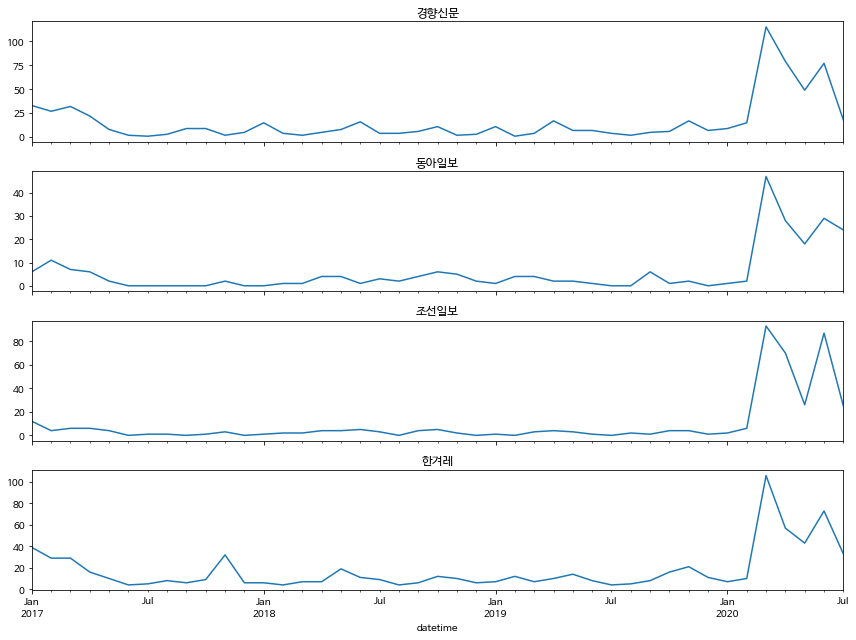

In [66]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
for i, (k, v) in enumerate(dfs.items()):
    v.resample('M').title.count().plot(ax=axes[i])
    axes[i].set_title(k)
plt.tight_layout()

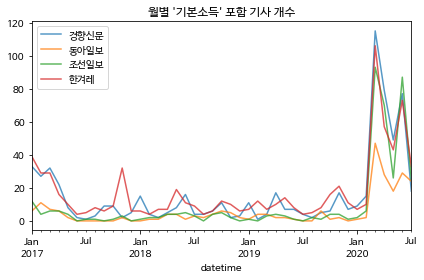

In [70]:
fig, ax = plt.subplots(1, 1, )
for k, v in dfs.items():
    v.resample('M').title.count().plot(ax=ax, label=k, alpha=0.75)
ax.legend()
ax.set_title("월별 '기본소득' 포함 기사 개수")
plt.tight_layout()

In [73]:
lengths = {k: v.shape[0] for k, v in dfs.items()}
overall_sum = sum(lengths.values())
print(lengths)
print(f"Total: {overall_sum}")

{'경향신문': 683, '동아일보': 239, '조선일보': 403, '한겨레': 746}
Total: 2071


In [77]:
dfs['경향신문'].extracted_category.value_counts().to_frame().head(20)

,extracted_category
사설,16
세상읽기,11
정동칼럼,10
경제와 세상,9
경향포럼,8
전문,7
오늘은 이런 경향,7
기고,6
편집국에서,4
헌법 11.0 다시 쓰는 시민계약,4


# Locating keyword

In [80]:
sentences = dfs['경향신문'].sentences.iloc[0]

In [9]:
bi = re.compile(r'기본 ?소득')

In [10]:
s = '30조를 갖고 기본소득이든 국민들 손에 기본소득을 쥐어주면 경제는 산다.”\n\n-외교·안보의 원칙은'
res = [m.span() for m in bi.finditer(s)]
print(res)

[(8, 12), (22, 26)]


# POS tagging

In [11]:
from konlpy.tag import Hannanum

In [12]:
hannanum = Hannanum()
# hannanum.analyze()

In [87]:
def extract_nouns(sentences):
    nouns = []
    for s in sentences:
        tagged_sentence = hannanum.pos(s)
        for w, t in tagged_sentence:
            if t == 'N':
                nouns.append(w)
    return nouns

a = dfs['동아일보'].sentences.apply(extract_nouns)

In [96]:
all_words = pd.concat([pd.Series(x) for x in a[a.index < pd.Timestamp(2020, 2, 25)].tolist()])

<ipython-input-96-99e1f33b87d5>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  all_words = pd.concat([pd.Series(x) for x in a[a.index < pd.datetime(2020, 2, 25)].tolist()])


In [98]:
all_words.value_counts().head(100)

것       505
수       279
등       222
원       208
이       168
       ... 
30       33
현금복지     33
명        33
이후       33
가능성      32
Length: 100, dtype: int64

In [ ]:
from sklearn.